In [ ]:
get_ipython().system('nvidia-smi')

Thu Aug 26 14:28:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pydoe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 파일 경로 설정
import os

os.chdir("/content/drive/MyDrive/PINN for Black sholes/Sampling_test")

In [ ]:
pwd

'/content/drive/My Drive/PINN for Black sholes/Sampling_test'

In [ ]:
GPU_NUM = 0 # 원하는 GPU 번호 입력

from IPython.display import clear_output, display

import torch
import torch.autograd as autograd         # 자동 미분
from torch import Tensor                  # 텐서 노드
import torch.nn as nn                     # 신경망
import torch.optim as optim               # 최적화

# 미니 배치 관련 함수
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# 쉬운 신경망 구성
from collections import OrderedDict

# 시각화 Tool
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

# 기타 Tool
import numpy as np
import time
from pyDOE import lhs

# ----------------------------------------
# 데이터 기본 형태 설정 float32
torch.set_default_dtype(torch.float)
# 파이토치 랜덤 시드
torch_seed_value = 1234
torch.manual_seed(torch_seed_value)
# 넘파이 랜덤 시드 (pydoe 의 random seed 값도 같이 지정됨)
np_seed_value = 1234
np.random.seed(np_seed_value)

# GPU 할당 ----------------
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check
# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  0
Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
# option 기본 정보
E = 100.0; sig = 0.4;
r = 0.03; q = 0.0;
T = 1; S_max = 3*E;

# put option : flag := -1 | call option : flag := 1
flag = 1

# Analytic solution
import scipy.stats as st
def exact_sol(x,t):
    tau=T-t
    d1 = (np.log(x/E) + (r -q +sig**2/2)*tau)/(sig*np.sqrt(tau))
    d2 = d1 - sig*np.sqrt(tau)
    Nd1 = st.norm.cdf(flag*d1)
    Nd2 = st.norm.cdf(flag*d2)
    exactsol = flag*(x*np.exp(-q*tau)*Nd1 -E*np.exp(-r*tau)*Nd2)

    return exactsol

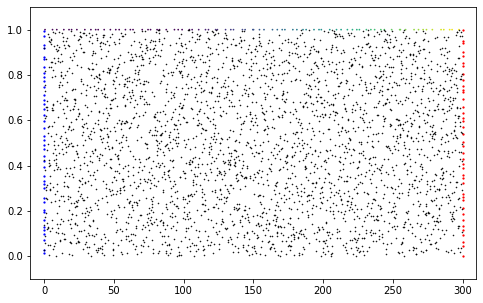

In [ ]:
## Sampling
# initial condition
N_0 = 80
u0_x = S_max*lhs(1,N_0)
u0_u = np.maximum(flag*(u0_x - E),0)

# boundary condtion
N_d = 40
bd_t1 = T*lhs(1,N_d); bd_t2 = T*lhs(1,N_d);
bd_x1 = 0.0*bd_t1; bd_x2 = 0.0*bd_t2 +S_max;
if flag == 1:
    bd_u1 = 0.0*bd_t1
    bd_u2 = bd_x2 -E*np.exp(-r*(T-bd_t2))
elif flag == -1:
    bd_u1 = E*np.exp(-r*(T -bd_t1))
    bd_u2 = exact_sol(bd_x2,bd_t2)
else:
    print("Check flag value")

# Interior points
N_f = 3200
lb = np.array([0,0])
ub = np.array([T, S_max])
X_f = (ub - lb)*lhs(2,N_f) + lb
it_t, it_x = X_f[:,0:1], X_f[:, 1:]

# Samping plot
u0_t = 0.0*u0_x +T;
plt.figure(figsize=(8, 5))
plt.scatter(u0_x, u0_t, c=u0_u , s=0.5)
plt.scatter(bd_x1, bd_t1, color='blue', s=1.5)
plt.scatter(bd_x2, bd_t2, color='red', s=1.5)
plt.scatter(it_x, it_t, color='black', s=0.3)
plt.xlim(-10,S_max + 10)
plt.ylim(-0.1,T + 0.1)
plt.show()

In [ ]:
## Network def
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # xavier initialization for weights
        def init_weights(m):
# sample

# Network parameter 갯수 확인
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return print(pp)

In [ ]:
# Model 및 Loss function 정의
class PhysicsInformedNN():
    def __init__(self, x0, t0, u0, x1_b, x2_b, t1_b, t2_b, u1_b, u2_b, x_f, t_f, NN):

        self.dnn = NN
        self.iter = 0
        self.volatility = 0.4
        self.risk_free = 0.03
        self.D0 = 0.0

        self.timestart=time.time()

# sample

In [ ]:
# layer 구성
layers = np.array([2,40,80,120,120,120,80,40,1])
PINN=DNN(layers).to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in PINN.state_dict():
    print(param_tensor, "\t", PINN.state_dict()[param_tensor].size())

# of parameters
get_n_params(PINN)

Model's state_dict:
layers.layer_0.weight 	 torch.Size([40, 2])
layers.layer_0.bias 	 torch.Size([40])
layers.layer_1.weight 	 torch.Size([80, 40])
layers.layer_1.bias 	 torch.Size([80])
layers.layer_2.weight 	 torch.Size([120, 80])
layers.layer_2.bias 	 torch.Size([120])
layers.layer_3.weight 	 torch.Size([120, 120])
layers.layer_3.bias 	 torch.Size([120])
layers.layer_4.weight 	 torch.Size([120, 120])
layers.layer_4.bias 	 torch.Size([120])
layers.layer_5.weight 	 torch.Size([80, 120])
layers.layer_5.bias 	 torch.Size([80])
layers.layer_6.weight 	 torch.Size([40, 80])
layers.layer_6.bias 	 torch.Size([40])
layers.layer_7.weight 	 torch.Size([1, 40])
layers.layer_7.bias 	 torch.Size([1])
55121


In [ ]:
# Sampling to device
x0 = torch.tensor(u0_x).float().to(device)
t0 = torch.tensor(u0_t).float().to(device)
u0 = torch.tensor(u0_u).float().to(device)

x1_b = torch.tensor(bd_x1).float().to(device)
x2_b = torch.tensor(bd_x2).float().to(device)
t1_b = torch.tensor(bd_t1).float().to(device)
t2_b = torch.tensor(bd_t2).float().to(device)
if flag == 1:
    u1_b = torch.tensor(bd_u1).float().to(device)
    u2_b = torch.tensor(bd_u2).float().to(device)
elif flag ==-1:
    u1_b = torch.tensor(bd_u1).float().to(device)
    u2_b = torch.tensor(bd_u2).float().to(device)

x_f = torch.tensor(it_x, requires_grad=True).float().to(device)
t_f = torch.tensor(it_t, requires_grad=True).float().to(device)

In [ ]:
Loss_Total=[]

# Frist optimization (Adam)
optimizer = torch.optim.Adam(PINN.parameters(), lr=0.001)
# sample

Training time: 0.61 Minutes


In [ ]:
# Second Optimization
# sample

Iter 1590, Loss: 7.59609e-01
Iter 1600, Loss: 7.58561e-01
Iter 1610, Loss: 7.58393e-01
Training time: 3.54 Minutes


FileNotFoundError: ignored

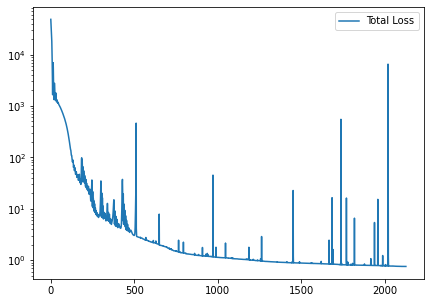

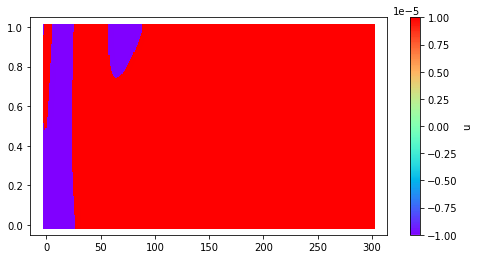

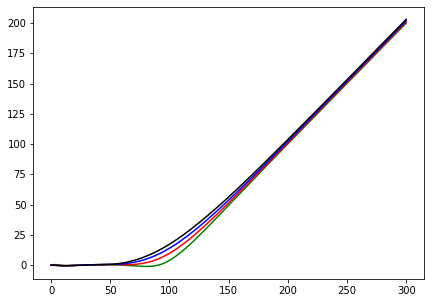

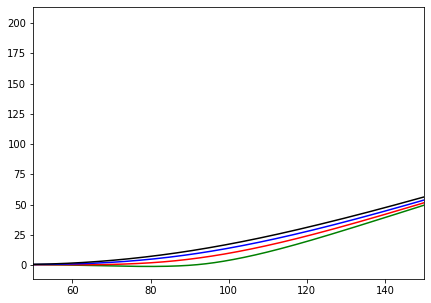

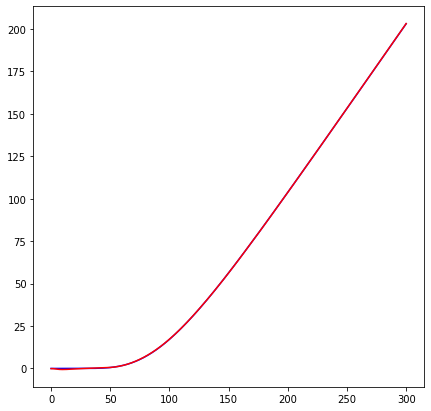

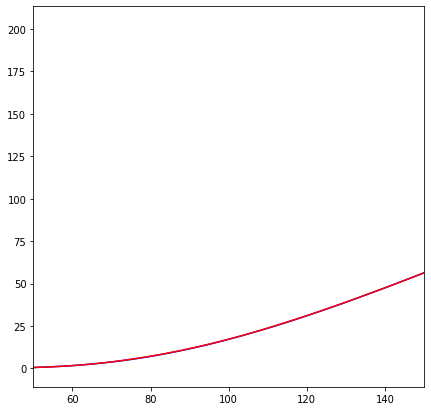

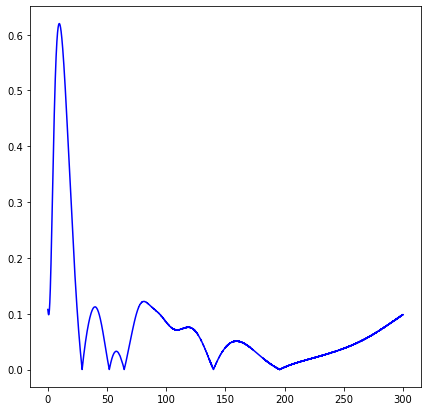

(0.13454510532448719, 0.07754440046412109, 0.6198103509691824)
(0.0013854221533934718, 0.0010865472380038655, 0.003053358955203983)
Call option
torch.manual_seed(1234)
np.random.seed(1234)
Training Time = 3.54 min
Total Iterations = 2127
Final Loss value = 7.58e-01
Relative L2 error = 0.0014
Relative L1 error = 0.0011
Relative L_inf error = 0.0031
absolute L2 error = 0.1345
absolute L1 error = 0.0775
absolute L_inf error = 0.6198


In [ ]:
# Total loss plot
plt.figure(figsize=(7, 5))
plt.semilogy(Loss_Total,label='Total Loss')
plt.legend()
plt.show()

##################################################
# Heat map plot
lb = np.array([0, 0])  # t, x
ub = np.array([T, S_max])  # t, x
t = np.arange(lb[0], ub[0], T/1000)
x = np.arange(lb[1], ub[1], 1.0)
tm, xm = np.meshgrid(t, x)
save_shape = x.shape
TT = tm.reshape((-1))
XX = xm.reshape((-1))
TT = np.c_[TT]
XX = np.c_[XX]

Nu = model.predict_u(XX,TT)


plt.figure(figsize=(8, 4))
plt.scatter(XX, TT, c=Nu, marker='s', alpha=0.9, cmap='rainbow')
plt.colorbar(label='u')
plt.clim([-0.00001, 0.00001])
plt.show()

#################################################
## Plot Predicted value at each time
# all domain
plt.figure(figsize=(7, 5))
lb = np.array([0, 0])  # t, x
ub = np.array([T, S_max])  # t, x
x = np.c_[np.arange(lb[1], ub[1], 0.1)]
t = 0.0 * x + T
Nu_ter3 = model.predict_u(x,t)

x = np.c_[np.arange(lb[1], ub[1], 0.1)]
t = 0.0 * x + 2*T/3
Nu_ter2 = model.predict_u(x,t)

x = np.c_[np.arange(lb[1], ub[1], 0.1)]
t = 0.0 * x + T/3
Nu_ter1 = model.predict_u(x,t)

x = np.c_[np.arange(lb[1], ub[1], 0.1)]
t = 0.0 * x + 0*T/3
Nu_ter0 = model.predict_u(x,t)

plt.plot(x,Nu_ter3,'-' , color='green')
plt.plot(x,Nu_ter2,'-' , color='red')
plt.plot(x,Nu_ter1,'-' , color='blue')
plt.plot(x,Nu_ter0,'-' , color='black')

plt.show()

# nearby strike price
plt.figure(figsize=(7, 5))
plt.plot(x,Nu_ter3,'-' , color='green')
plt.plot(x,Nu_ter2,'-' , color='red')
plt.plot(x,Nu_ter1,'-' , color='blue')
plt.plot(x,Nu_ter0,'-' , color='black')
plt.xlim([E -0.5*E,E + 0.5*E])

plt.show()

######################################################
# Plot analytic solution and numerical
lb = np.array([0, 0.01])  # t, x
ub = np.array([T, S_max])  # t, x
x = np.c_[np.arange(lb[1], ub[1], 0.01)]
t = 0.0 * x + 0.0
neural_u = model.predict_u(x,t)
exact_u = exact_sol(x,t)

plt.figure(figsize=(7,7))
plt.plot(x,exact_u,'-',color = 'blue')
plt.plot(x,neural_u,'-',color='red')

# nearby strike price


plt.figure(figsize=(7,7))
plt.plot(x,exact_u,'-',color = 'blue')
plt.plot(x,neural_u,'-',color='red')
plt.xlim([E -0.5*E,E + 0.5*E])
# plt.ylim([-5,30])

plt.show()

######################################################
# Error plot
plt.figure(figsize=(7,7))
plt.plot(x,abs(exact_u-neural_u),'-',color = 'blue')

plt.show()

######################################################
# Absolute Error
abs_l2 = np.sqrt(np.mean((neural_u - exact_u)**2))
abs_l1 = np.mean(np.abs(neural_u - exact_u))
abs_linf= np.max(np.abs(neural_u - exact_u))

print((abs_l2,abs_l1,abs_linf))

# Relative error
rel_l2 = np.sqrt(np.mean((neural_u - exact_u)**2))/np.sqrt(np.mean((exact_u)**2))
rel_l1 = np.mean(np.abs(neural_u - exact_u))/np.mean(np.abs(exact_u))
rel_linf= np.max(np.abs(neural_u - exact_u))/np.max(np.abs(exact_u))

print((rel_l2,rel_l1,rel_linf))

# Summary
if flag == 1:
    print('Call option')
elif flag == -1:
    print('Put option')
print('torch.manual_seed(%d)'%torch_seed_value)
print('np.random.seed(%d)'%np_seed_value)
print('Training Time = %.2f min' %(elapsed/60))
print('Total Iterations = %d' %(len(Loss_Total)))
print('Final Loss value = %.2e' %(Loss_Total[-1]))
print('Relative L2 error = %.4f' %(rel_l2))
print('Relative L1 error = %.4f' %(rel_l1))
print('Relative L_inf error = %.4f' %(rel_linf))
print('absolute L2 error = %.4f' %(abs_l2))
print('absolute L1 error = %.4f' %(abs_l1))
print('absolute L_inf error = %.4f' %(abs_linf))

In [ ]:
# Third Optimization
# sample

Iter 31590, Loss: 6.79632e-02
Iter 31600, Loss: 6.79469e-02
Iter 31610, Loss: 6.79353e-02
Training time: 40.17 Minutes


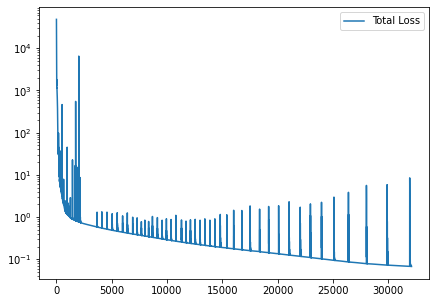

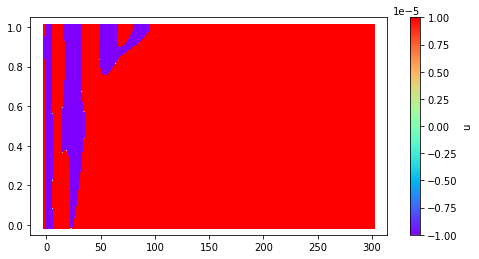

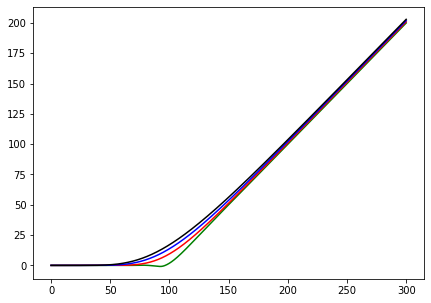

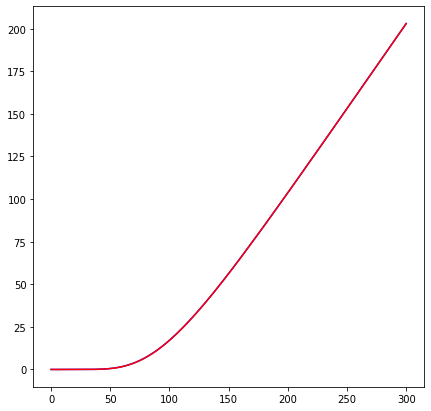

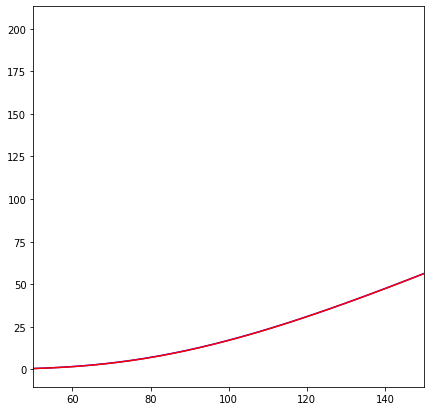

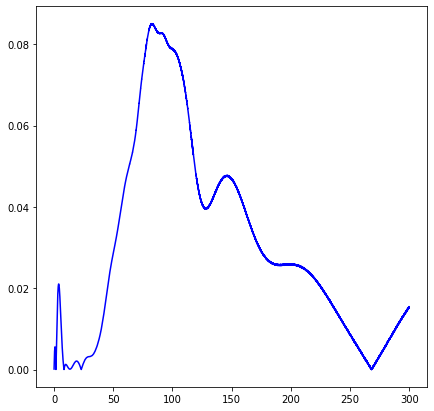

Call option
torch.manual_seed(1234)
np.random.seed(1234)
Training Time = 40.17 min
Total Iterations = 32127
Final Loss value = 6.79e-02
Relative L2 error = 0.0004
Relative L1 error = 0.0004
Relative L_inf error = 0.0004
absolute L2 error = 0.0394
absolute L1 error = 0.0307
absolute L_inf error = 0.0851


In [ ]:
# Total loss plot
plt.figure(figsize=(7, 5))
plt.semilogy(Loss_Total,label='Total Loss')
plt.legend()
plt.show()

##################################################
# Heat map plot
lb = np.array([0, 0])  # t, x
ub = np.array([T, S_max])  # t, x
t = np.arange(lb[0], ub[0], T/1000)
x = np.arange(lb[1], ub[1], 1.0)
tm, xm = np.meshgrid(t, x)
save_shape = x.shape
TT = tm.reshape((-1))
XX = xm.reshape((-1))
TT = np.c_[TT]
XX = np.c_[XX]

Nu = model.predict_u(XX,TT)


plt.figure(figsize=(8, 4))
plt.scatter(XX, TT, c=Nu, marker='s', alpha=0.9, cmap='rainbow')
plt.colorbar(label='u')
plt.clim([-0.00001, 0.00001])
plt.show()


#################################################
## Plot Predicted value at each time
# all domain
plt.figure(figsize=(7, 5))
lb = np.array([0, 0])  # t, x
ub = np.array([T, S_max])  # t, x
x = np.c_[np.arange(lb[1], ub[1], 0.1)]
t = 0.0 * x + T
Nu_ter3 = model.predict_u(x,t)

x = np.c_[np.arange(lb[1], ub[1], 0.1)]
t = 0.0 * x + 2*T/3
Nu_ter2 = model.predict_u(x,t)

x = np.c_[np.arange(lb[1], ub[1], 0.1)]
t = 0.0 * x + T/3
Nu_ter1 = model.predict_u(x,t)

x = np.c_[np.arange(lb[1], ub[1], 0.1)]
t = 0.0 * x + 0*T/3
Nu_ter0 = model.predict_u(x,t)

plt.plot(x,Nu_ter3,'-' , color='green')
plt.plot(x,Nu_ter2,'-' , color='red')
plt.plot(x,Nu_ter1,'-' , color='blue')
plt.plot(x,Nu_ter0,'-' , color='black')

plt.show()

######################################################


# Plot analytic solution and numerical
lb = np.array([0, 0.01])  # t, x
ub = np.array([T, S_max])  # t, x
x = np.c_[np.arange(lb[1], ub[1], 0.01)]
t = 0.0 * x + 0.0
neural_u = model.predict_u(x,t)
exact_u = exact_sol(x,t)

plt.figure(figsize=(7,7))
plt.plot(x,exact_u,'-',color = 'blue')
plt.plot(x,neural_u,'-',color='red')

# nearby strike price


plt.figure(figsize=(7,7))
plt.plot(x,exact_u,'-',color = 'blue')
plt.plot(x,neural_u,'-',color='red')
plt.xlim([E -0.5*E,E + 0.5*E])
# plt.ylim([-5,30])

plt.show()

######################################################
# Error plot
plt.figure(figsize=(7,7))
plt.plot(x,abs(exact_u-neural_u),'-',color = 'blue')

plt.show()

# Absolute Error
abs_l2 = np.sqrt(np.mean((neural_u - exact_u)**2))
abs_l1 = np.mean(np.abs(neural_u - exact_u))
abs_linf= np.max(np.abs(neural_u - exact_u))

# Relative error
rel_l2 = np.sqrt(np.mean((neural_u - exact_u)**2))/np.sqrt(np.mean((exact_u)**2))
rel_l1 = np.mean(np.abs(neural_u - exact_u))/np.mean(np.abs(exact_u))
rel_linf= np.max(np.abs(neural_u - exact_u))/np.max(np.abs(exact_u))

# Summary
if flag == 1:
    print('Call option')
elif flag == -1:
    print('Put option')
print('torch.manual_seed(%d)'%torch_seed_value)
print('np.random.seed(%d)'%np_seed_value)
print('Training Time = %.2f min' %(elapsed/60))
print('Total Iterations = %d' %(len(Loss_Total)))
print('Final Loss value = %.2e' %(Loss_Total[-1]))
print('Relative L2 error = %.4f' %(rel_l2))
print('Relative L1 error = %.4f' %(rel_l1))
print('Relative L_inf error = %.4f' %(rel_linf))
print('absolute L2 error = %.4f' %(abs_l2))
print('absolute L1 error = %.4f' %(abs_l1))
print('absolute L_inf error = %.4f' %(abs_linf))